<a href="https://colab.research.google.com/github/Aduboahen/Aduboahen/blob/main/HW6_Proteomics_Student_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 6 - Proteomics**
The purpose of this homework is to teach you how to identify significantly differential protein abundances and how to identify significant correlation between proteins.

License: This document is open source under [CC BY-ND 4.0](https://en.wikipedia.org/wiki/Creative_Commons_license).

# **Completing the Assignment**

This notebook is your homework #6. To complete the homework and receive credit, you need to work through all 5 sections. Within each thematic section is a mix of explanatory text cells and code cells. Some code cells have code written for you; some ask you to write code. At the end of each section are 'Practice Problems'. You should write code to answer the questions - following the directions given. Once you are ready to submit your answer, run the submission code block below every question block. If you get a question wrong, fix your code and try again. If you get stumped, ask for a hint using the hint code block below each submission code block. This homework also has several sections of code that might take a few minutes. 

Your first step will be to save this notebook as a copy so that you can edit it. (File->Save a copy in Drive).

Have fun.

# **Learning Outcomes**
#### Biological 

*   Evaluate utility of protein coexpression networks based on agreement with known protein interaction networks.

#### Computational

*   Perform correlation analysis.
*   Create network visualization.
*   Access UniProt knowledgebase using API.

# **Topics and Background Reading**

[Proteomics](https://en.wikipedia.org/wiki/Proteomics) is the comprehensive measurement of protein abundance. Proteins are the dominant functional molecule in cellular life. Proteins are the structural support of a cell (i.e. the cytoskeleton); proteins perform metabolic conversion and control energy flow in a cell; and proteins sense the environment and generate signals to trigger a response to the environment. 

In our cancer datasets, we typically get an abundance measurement for more than 10,000 proteins in each tumor sample. The majority of proteomics measurements are obtained via [mass spectrometry](https://en.wikipedia.org/wiki/Mass_spectrometry). In our dataset, the quantitative measurement is a relative abundance, meaning we ask the question, "Does a sample have more/less of a protein than the 'average' sample?" More detail on this is given below. First, let's read some manuscripts about the data generation and statistical challenges in the field.

* [Aebersold 2003](https://pubmed.ncbi.nlm.nih.gov/12634793/)
* [Nesvizhskii 2005](https://pubmed.ncbi.nlm.nih.gov/16009968/)
* [Piazza 2018](https://pubmed.ncbi.nlm.nih.gov/29307493/)
* [Dou 2020](https://pubmed.ncbi.nlm.nih.gov/32059776/)

# Part 1. Setup


First we need to install and import the cptac and biograder packages along with a few other packages.

In [ ]:
!pip install cptac
!pip install biograder

We will be working with three similar cancer cohorts in this homework. Examples will be shown to you with the lung adenocarcinoma (LUAD) cohort. Afterwards some questions will ask you to perform analyses on the lung squamous cell carcinoma (LSCC) cohort and the head/neck squamous cell carcinoma (HNSCC) cohort for comparision. 

In [ ]:
#Be patient, this may take a few minutes depending on your internet connection.
import cptac

cptac.download('luad')
lu = cptac.Luad()
cptac.download('lscc')
ls = cptac.Lscc()
cptac.download('hnscc')
hn = cptac.Hnscc()

We have to import a couple more packages that we will used throughout the homework.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
import statistics

Lastly, we need to get the homework autograder. This will have the same steps of server install, importing and object creation.

In [ ]:
import biograder
#The proteomics homework is #6
biograder.download("bio462_hw6")
myID = "Place_Your_ID_Here" #Your student id, or 'temp'
hw = biograder.bio462_hw6(student_id = myID) #Instantiate the homework grader object.

For this lesson we need to get the joined clinical and proteomics dataframe for tumor and normal tissue from the LUAD cohort.

In [ ]:
import cptac.utils as ut

lu_clin_prot = lu.join_metadata_to_omics(metadata_df_name='clinical', 
  omics_df_name='proteomics', 
  metadata_cols = ["Sample_Tumor_Normal"])
#Some functions require that we drop the Database_ID column. 
luad_no_id = ut.reduce_multiindex(df=lu_clin_prot, levels_to_drop="Database_ID")
luad_no_id

# Part 2. Protein Correlation

In HW5 we learned about differential expression, what transcripts are changing between conditions. In this lesson we learn about how to assess which proteins are changing in a similar way. This is sometimes called co-expression analysis. Today we'll call this correlation, because that is evocative of the statistical test.

Linear regression can help us determine how a change in abundance for one protein might predict the abundance of another protein.
We can create a scatterplot with seaborn in order to measure the linear regression between two ribosomal proteins known as RPS13 and RPS11. 

In [ ]:
from scipy.stats import linregress
tumor_type = lu_clin_prot.loc[lu_clin_prot['Sample_Tumor_Normal'] == 'Tumor']
plot = sns.regplot(x=tumor_type['RPS13_proteomics'], y=tumor_type['RPS11_proteomics'])
plt.xlabel('RPS13',fontsize=16)
plt.ylabel('RPS11',fontsize=16)
plot_results = linregress(plot.get_lines()[0].get_xdata(),plot.get_lines()[0].get_ydata())
print('slope =', round(plot_results[0],5),'y-intercept =', round(plot_results[1],5))

Linear regression is a way to build a prediction formula, given proteinX I can predit the value of proteinY. That comes from the slope and y-intercept you see printed above. 

Correlation is not a prediction method, but just a measure of how similar the abundance patterns of the two proteins is. This is done using pearsonr() from the scipy.stats package which uses the [Pearson method](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient). In the code below, we call the function and print out both the correlation coefficient and p-value. 

In [ ]:
corr,pval = stats.pearsonr(luad_no_id['RPS13_proteomics'], luad_no_id['RPS11_proteomics'])
print("Correlation:", corr, "\nP-value:", pval)

We can see that the correlation coefficient is 0.83 which indicates a strong positive linear correlation between RPS13 and RPS11. The p-value of 6.11e-57 tells us that this correlation is statistically significant. These two ribosomal proteins physically interact and make up part of the small subunit of a ribosome. So it makes sense that their protein abundance would be highly correlated.

Now you try. Calculate the correlation coefficients for two other genes: PTEN and CDC27.

In [ ]:
#Get the correlation coefficient for PTEN and CDC27.
##  Your code here  ##


As you can see, PTEN and CDC27 have a negative correlation coefficient and a p-value < 0.05. Think about what that means for their interaction.

We want to get the correlation coefficient between every protein within the entire proteomics dataframe. To do this we use the .corr() function. As you investigate this, note that the resulting dataframe only has correlation coefficients and not p-values. The .corr() function only computes that; it does not compute p-values.

In [ ]:
#Be patient, this may take a minute depending on your internet connection. 
lu_proteomics = lu.get_proteomics()
lu_prot_no_id = ut.reduce_multiindex(df=lu_proteomics, levels_to_drop="Database_ID")
lu_correlation = lu_prot_no_id.corr(method='pearson')
lu_correlation.head(50)

###Note for Practice Problems

Computing a correlation in a dataframe with df.corr() is rather quick. Doing the same with scipy.stats.pearsonr() would be a lot slower because it is calculating the correlation coefficient along with the p-value - and calculating the p-value is slow if you're doing it a million times in our large df. 

For efficiency in this homework, we have decided to use <-0.3 and >0.3 as the critical value for a 'significant' correlation. It's a reasonable assumption based on our experience with this dataset. But we note that it is not a strictly 'statistical' cutoff. Also in this homework, a strong correlation is <-0.6 and >0.6. In the real world, calculating and using the p-value would be necessary. Here we're just trying to save ~30-60 minutes of CPU thrashing. 

##PRACTICE PROBLEMS
1. For MSH2 in the LUAD correlation data, which protein has the highest correlation coefficient?

In [ ]:
###       Question 1         ###
#  For MSH2 in the LUAD correlation data, which protein has the highest correlation coefficient?
#  You should derive your answer with coding, not any shortcuts.

###      Your code here      ###


In [ ]:
###  Question 1: Submitting the answer   ###
# To submit, your code above should have created a variable 'answer_1'. 
result = hw.submit(question = 1, answer = answer_1)
print(result)

In [ ]:
### Question 1: Getting help ###
hints = hw.getHint(question=1)
print(hints)

2. How many proteins have a positive correlation with TP53 in all of the following tumor types: LUAD, LSCC, HNSCC?

In [ ]:
###       Question 2         ###
#  How many proteins have a positive correlation with TP53 in all of the following tumor types: LUAD, LSCC, HNSCC?
#  Your answer should be in the format "cancer_# of proteins".
#  Each cancer should be in alphabetical order and separated by a comma and a space.
#  e.g. HNSCC_4209, LSCC_2384,...
#  You should derive your answer with coding, not any shortcuts.

###      Your code here      ###


In [ ]:
###  Question 2: Submitting the answer   ###
# To submit, your code above should have created a variable 'answer_2'. 
result = hw.submit(question = 2, answer = answer_2)
print(result)

In [ ]:
### Question 2: Getting help ###
hints = hw.getHint(question=2)
print(hints)

# Part 3. Correlation Networks

There is a great visual map called a correlation or [co-expression network](https://en.wikipedia.org/wiki/Gene_co-expression_network), where we can see the similarity of protein abundance based on their correlation coefficients. If we made one with our complete correlation network, it would use so much RAM that it would crash our colab; It would look something like this.

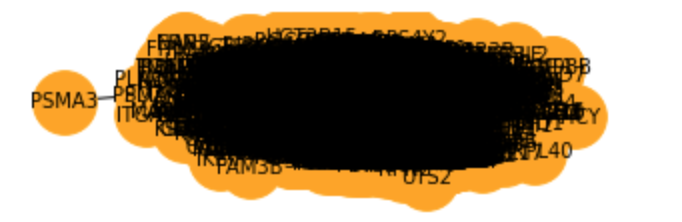

This is called a hairball and it is not good. We can't learn anything from this network! It would be much better to look at a few genes and their interactions. Let's look at our ribosomal proteins, RPS13 and RPS11, since we know they are highly correlated.

In [ ]:
#Get the correlation between RPS13 and RPS11.
rps_interactions = lu_correlation[['RPS13', 'RPS11']]
rps_interactions.columns.name = 'gene1'
rps_interactions.index.name = 'gene2'
rps_links = rps_interactions.stack().reset_index()
rps_links.columns = ['gene1', 'gene2', 'value']

print(rps_links)

In [ ]:
import networkx as nx
#Keep only correlation over a threshold and remove self correlation (cor(A,A)=1).
rps_links_filtered=rps_links.loc[(rps_links['value'] > 0.6) & (rps_links['gene1'] != rps_links['gene2'])]
 
#Build your graph.
rps_G=nx.from_pandas_edgelist(rps_links_filtered, 'gene1', 'gene2')
 
#Plot the network.
nx.draw(rps_G, with_labels=True, node_color='orange', node_size=1000, edge_color='black', linewidths=1, font_size=10)


In the middle of this image is a tightly clustered group of proteins from the ribosome. You can spot them by their names 'RPL#' and 'RPS#', including RPS11 and RPS13. This bunch is highly connected with each other. At the edge of the image you also see a cresent moon shaped group of proteins that are only connected to RPS11, and not the rest of the network. This points to a distinct function of RPS11. 

Let's look at PTEN and CDC27 to see the type of correlation network they have.

In [ ]:
#Make a correlation network with PTEN and CDC27.
###   Your code here  ###


So, different.\
PTEN and CDC27 are each isolated on their own small network. Their correlation coefficient was negative, so it was unlikely that they had a lot in common. 

## PRACTICE PROBLEMS

3. In the breast cancer cohort, how many proteins have a significant positive correlation with ERBB2 in stage III?

In [ ]:
###       Question 3         ###
#  In the breast cancer cohort, how many proteins have a significant positive correlation with ERBB2 in stage III?
#  You should derive your answer with coding, not any shortcuts.

###      Your code here      ###
# HINT. to access breast cancer data, use - 
cptac.download('brca')
br = cptac.Brca()


In [ ]:
###  Question 3: Submitting the answer   ###
# To submit, your code above should have created a variable 'answer_3'. 
result = hw.submit(question = 3, answer = answer_3)
print(result)

In [ ]:
### Question 3: Getting help ###
hints = hw.getHint(question=3)
print(hints)

4. In the breast cancer cohort, how many proteins have a significant positive correlation with ERBB2 in stage II?

In [ ]:
###       Question 4         ###
#  In the breast cancer cohort, how many proteins have a significant positive correlation with ERBB2 in stage II?
#  You should derive your answer with coding, not any shortcuts.

###      Your code here      ###


In [ ]:
###  Question 4: Submitting the answer   ###
# To submit, your code above should have created a variable 'answer_4'. 
result = hw.submit(question = 4, answer = answer_4)
print(result)

In [ ]:
### Question 4: Getting help ###
hints = hw.getHint(question=4)
print(hints)

5. In the LUAD cohort, we previously made an interaction network with RPS11 that included the ribosome and associated translational machinery. Which proteins have a highly negative interaction with RPS11?

In [ ]:
###       Question 5         ###
#  In the LUAD cohort, we previously made an interaction network with RPS11 that included the ribosome and associated translational machinery. 
#  Which proteins have a highly negative interaction with RPS11?
#  Your answer should be a string with each protein separated by a comma and a space in alphabetical order.
#  You should derive your answer with coding, not any shortcuts.

###      Your code here      ###


In [ ]:
###  Question 5: Submitting the answer   ###
# To submit, your code above should have created a variable 'answer_5'. 
result = hw.submit(question = 5, answer = answer_5)
print(result)

In [ ]:
### Question 5: Getting help ###
hints = hw.getHint(question=5)
print(hints)

# Part 4. Interactions

It is now important to compare the results we have found to the known interactions in UniProt.

In [ ]:
import urllib.parse
import urllib.request

url = 'https://www.uniprot.org/uniprot/'

params = {
    'format': 'list',
    'query': 'gene_exact:pten AND organism:homo_sapiens AND reviewed:yes'
}

data = urllib.parse.urlencode(params)
data = data.encode('utf-8')
req = urllib.request.Request(url, data)
f = urllib.request.urlopen(req)
response = f.read()
pten_accession = (response.decode('utf-8')).rstrip()
print(pten_accession)

In [ ]:
import requests
interactions_response = requests.get('https://www.ebi.ac.uk/proteins/api/proteins/interaction/' + pten_accession)
print(type(interactions_response))
print(interactions_response.text)

In [ ]:
#the python library to help with JSON objects
import json
json_var_dictionary = json.loads(interactions_response.text)
json_var_dictionary #look at the information provided in this dictionary and try to understand the output

In [ ]:
#Select out the genes for humans from json_var_dictionary that interact with PTEN and put them in an array.
###   Your code here  ###   


It is interesting to look at the interactions that have been found with the PTEN gene. If you notice, CDC27 is on the list of interacting proteins, when we earlier found they had no interaction based on their correlation network. This gives an interesting problem in the world of bioinformatics. You can do a lot of different analyses, but even if you have found something, that does not mean it's completely true or relevant. There can also be factors that are hard to recognize. It could be that the genes correlate regularly, but correlate differently in cancerous tissue. This is a good start to understanding protein-protein interactions, but there is much more to be considered and studied before we get the full picture of cancer.

## PRACTICE PROBLEM

6. Which one of the interacting proteins with PTEN from UniProt shows the highest correlation in our LUAD correlation dataframe, excluding its correlation with itself?

In [ ]:
###       Question 6         ###
#  Which one of the interacting proteins with PTEN from UniProt shows the highest correlation in our LUAD correlation 
#  dataframe, excluding its correlation with itself?
#  Your answer should be in the format "gene:correlation value" with the value rounded to 3 decimal places.
#  e.g DBN1:0.736
#  You should derive your answer with coding, not any shortcuts.

###      Your code here      ###


In [ ]:
###  Question 6: Submitting the answer   ###
# To submit, your code above should have created a variable 'answer_6'. 
result = hw.submit(question = 6, answer = answer_6)
print(result)

In [ ]:
### Question 6: Getting help ###
hints = hw.getHint(question=6)
print(hints)

# Part 5. Turn it in
**Congrats!**

Now that you have finished the assignment, use the endSession command to report your score. Once you have completed the notebook, please share it with your instructor.

In [ ]:
hw.endSession()